https://www.kaggle.com/jphoon/bitcoin-time-series-prediction-with-lstm/notebook

In [2]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import plotly.offline as py
import plotly.graph_objs as go
import numpy as np
import seaborn as sns
py.init_notebook_mode(connected=True)
%matplotlib inline

In [4]:
data = pd.read_csv('data/train.csv')
# val_df = pd.read_csv('data/validate.csv')

In [10]:
def mkdt(df):
    # 피처를 시계열 피처로 변환
    df['날짜'] = df['날짜'].astype(str)
    df['날짜'] = pd.to_datetime(df['날짜'])

    df['시간'] = pd.to_datetime(df['시간'], format='%H').dt.time

    # 날짜와 시간 합쳐서 datetime으로 변경
    df['날짜시간'] = pd.to_datetime(df['날짜'].astype(str) + df['시간'].astype(str), format='%Y-%m-%d%H:%M:%S')
    df = df.drop(['시간','날짜'], axis=1)
    
    return df

In [11]:
mkdt(data)

,10,100,101,120,121,140,150,160,200,201,...,1040,1100,1200,1510,2510,3000,4510,5510,6000,날짜시간
0,83247,19128,2611,5161,1588,892,32263,1636,7938,1894,...,3482,11299,7072,1176,3810,748,3920,2133,3799,2020-01-01 00:00:00
1,89309,19027,3337,5502,1650,1043,35609,1644,9896,1967,...,3849,13180,8771,1283,3763,782,3483,2057,4010,2020-01-01 01:00:00
2,66611,14710,2970,4631,1044,921,26821,1104,9343,1838,...,2299,7986,5426,1536,3229,491,2634,1526,3388,2020-01-01 02:00:00
3,53290,13753,2270,4242,1021,790,21322,909,10009,1630,...,1716,5703,3156,1104,2882,431,2488,1268,3686,2020-01-01 03:00:00
4,52095,17615,2406,3689,1840,922,22711,1354,15497,1264,...,2421,5816,2933,1206,2433,499,2952,1927,5608,2020-01-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3307,311727,101285,10085,30637,10060,8749,148935,6801,26101,9370,...,15431,25597,14292,9300,22238,3786,16936,10729,20194,2020-05-17 19:00:00
3308,305354,91426,8607,26021,8095,7198,136503,6147,20759,8432,...,15378,24661,14747,8239,20604,3203,15018,9767,17962,2020-05-17 20:00:00
3309,306008,75113,6325,19933,5711,4494,129412,5134,14496,6739,...,12558,22781,14081,6392,17937,2447,12403,7825,14031,2020-05-17 21:00:00
3310,237447,49498,4209,12145,3891,2718,96698,3526,9363,4543,...,8870,16640,11066,4427,11955,1495,7507,5387,8889,2020-05-17 22:00:00


In [13]:
btc_trace = go.Scatter(x=data.iloc[-1], y=data['10'], name='교통량')
py.iplot([btc_trace])

In [15]:
from sklearn.preprocessing import MinMaxScaler

values = data['10'].values.reshape(-1,1)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [16]:
train_size = int(len(scaled) * 0.7)
test_size = len(scaled) - train_size
train, test = scaled[0:train_size,:], scaled[train_size:len(scaled),:]
print(len(train), len(test))

2318 994


In [17]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [18]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

2317
993


In [19]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [22]:
model = Sequential()
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
history = model.fit(trainX, trainY, epochs=300, batch_size=100, validation_data=(testX, testY), verbose=0, shuffle=False)

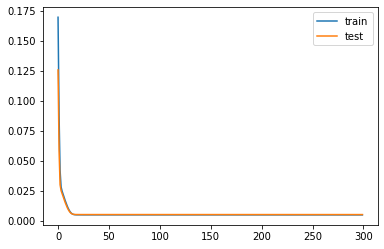

In [23]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
yhat = model.predict(testX)
pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()